In [87]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pickle
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from pandas.tseries.holiday import USFederalHolidayCalendar as holiday_calendar

import warnings
warnings.filterwarnings('ignore')
 
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
# import plotly.graph_objects as go
# from sklearn.decomposition import PCA

In [2]:
# TO DO

# Feature Engineering:
#     weather_dept: add API details (wind, precipitation, temp) -- maybe search what regulartions are for takeoff
#     weather_arr: "
#     traffic: needs redefining: # planes (tail #) using runways during same departure hour -- Bonus: find # runways per airport
#     knock-on: by plane (tail #) find differnce between scheduled arrival and next departure

# Cleaning: 
#    Scale features (doesn't have to be minmax)

# IMPROVEMENTS:
    # stratified K-fold without for loop
    # udf: Get hour and minute from int, re-structured as int. then can easily get flights within 0.5 or 1h

In [3]:
# Load the dataset
df = pd.read_csv('Supervised-Learning-Project/flights_sample_medium.csv')
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0
1,2019-01-01,AA,5628,OH,N260JS,14492,RDU,"Raleigh/Durham, NC",11278,DCA,"Washington, DC",1036,1145,69,227,-18.0
2,2019-01-01,AA,5629,OH,N589NN,11057,CLT,"Charlotte, NC",12217,HSV,"Huntsville, AL",2240,2310,90,333,62.0
3,2019-01-01,AA,5632,OH,N598NN,11057,CLT,"Charlotte, NC",13296,MHT,"Manchester, NH",949,1203,134,737,-12.0
4,2019-01-01,AA,5632,OH,N598NN,13296,MHT,"Manchester, NH",11057,CLT,"Charlotte, NC",1239,1513,154,737,0.0


In [4]:
# size of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145364 entries, 0 to 145363
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fl_date             145364 non-null  object 
 1   mkt_unique_carrier  145364 non-null  object 
 2   mkt_carrier_fl_num  145364 non-null  int64  
 3   op_unique_carrier   145364 non-null  object 
 4   tail_num            145364 non-null  object 
 5   origin_airport_id   145364 non-null  int64  
 6   origin              145364 non-null  object 
 7   origin_city_name    145364 non-null  object 
 8   dest_airport_id     145364 non-null  int64  
 9   dest                145364 non-null  object 
 10  dest_city_name      145364 non-null  object 
 11  crs_dep_time        145364 non-null  int64  
 12  crs_arr_time        145364 non-null  int64  
 13  crs_elapsed_time    145364 non-null  int64  
 14  distance            145364 non-null  int64  
 15  arr_delay           145053 non-nul

# Feature Engineering
##### target variable, departure hour, departure day of week

In [5]:
def get_hour_from_int(x):
    if len(x) == 4:
        return int(x[:2])
    return int(x[0])

In [6]:
# Set Binary target variable. 
df['delay_yn'] = np.where(df['arr_delay'] <= 0, 0, 1)
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0,0
1,2019-01-01,AA,5628,OH,N260JS,14492,RDU,"Raleigh/Durham, NC",11278,DCA,"Washington, DC",1036,1145,69,227,-18.0,0
2,2019-01-01,AA,5629,OH,N589NN,11057,CLT,"Charlotte, NC",12217,HSV,"Huntsville, AL",2240,2310,90,333,62.0,1
3,2019-01-01,AA,5632,OH,N598NN,11057,CLT,"Charlotte, NC",13296,MHT,"Manchester, NH",949,1203,134,737,-12.0,0
4,2019-01-01,AA,5632,OH,N598NN,13296,MHT,"Manchester, NH",11057,CLT,"Charlotte, NC",1239,1513,154,737,0.0,0


In [88]:
df['fl_date'] = df['fl_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

TypeError: strptime() argument 1 must be str, not Timestamp

In [8]:
# holiday_cal
cal = holiday_calendar()
dr = df['fl_date'] 
holidays = cal.holidays(start=dr.min(), end=dr.max())
df['holiday'] = df['fl_date'].dt.date.astype('datetime64').isin(holidays).astype(int)
df.tail(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn,holiday
145359,2019-01-07,UA,3656,YX,N744YX,11618,EWR,"Newark, NJ",11057,CLT,"Charlotte, NC",1645,1848,123,529,2.0,1,0
145360,2019-01-07,UA,3657,YX,N743YX,11057,CLT,"Charlotte, NC",12266,IAH,"Houston, TX",1830,2035,185,912,0.0,0,0
145361,2019-01-07,UA,3658,YX,N750YX,13487,MSP,"Minneapolis, MN",11618,EWR,"Newark, NJ",1225,1615,170,1008,-7.0,0,0
145362,2019-01-07,UA,3659,YX,N863RW,10781,BTR,"Baton Rouge, LA",12266,IAH,"Houston, TX",525,643,78,253,-27.0,0,0
145363,2019-01-07,UA,3660,YX,N641RW,11618,EWR,"Newark, NJ",10994,CHS,"Charleston, SC",1405,1623,138,628,-6.0,0,0


In [9]:
df['dep_day_of_week'] = df['fl_date'].dt.day_name()
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn,holiday,dep_day_of_week
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,"Charlotte, NC",620,956,156,815,-7.0,0,1,Tuesday
1,2019-01-01,AA,5628,OH,N260JS,14492,RDU,"Raleigh/Durham, NC",11278,DCA,"Washington, DC",1036,1145,69,227,-18.0,0,1,Tuesday
2,2019-01-01,AA,5629,OH,N589NN,11057,CLT,"Charlotte, NC",12217,HSV,"Huntsville, AL",2240,2310,90,333,62.0,1,1,Tuesday
3,2019-01-01,AA,5632,OH,N598NN,11057,CLT,"Charlotte, NC",13296,MHT,"Manchester, NH",949,1203,134,737,-12.0,0,1,Tuesday
4,2019-01-01,AA,5632,OH,N598NN,13296,MHT,"Manchester, NH",11057,CLT,"Charlotte, NC",1239,1513,154,737,0.0,0,1,Tuesday


In [10]:
df['dep_hour'] = df['crs_dep_time'].map(str).apply(lambda x: get_hour_from_int(x))
df['arr_hour'] = df['crs_arr_time'].map(str).apply(lambda x: get_hour_from_int(x))
df.head(5)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,...,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,delay_yn,holiday,dep_day_of_week,dep_hour,arr_hour
0,2019-01-01,AA,5677,OH,N576NN,11423,DSM,"Des Moines, IA",11057,CLT,...,620,956,156,815,-7.0,0,1,Tuesday,6,9
1,2019-01-01,AA,5628,OH,N260JS,14492,RDU,"Raleigh/Durham, NC",11278,DCA,...,1036,1145,69,227,-18.0,0,1,Tuesday,10,11
2,2019-01-01,AA,5629,OH,N589NN,11057,CLT,"Charlotte, NC",12217,HSV,...,2240,2310,90,333,62.0,1,1,Tuesday,22,23
3,2019-01-01,AA,5632,OH,N598NN,11057,CLT,"Charlotte, NC",13296,MHT,...,949,1203,134,737,-12.0,0,1,Tuesday,9,12
4,2019-01-01,AA,5632,OH,N598NN,13296,MHT,"Manchester, NH",11057,CLT,...,1239,1513,154,737,0.0,0,1,Tuesday,12,15


# Extra: 
##### variable visualization and encoding

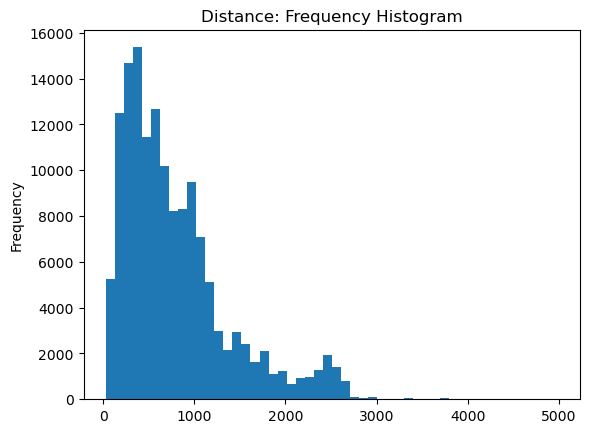

In [21]:
plt.hist(df['distance'], bins=50)
plt.gca().set(title='Distance: Frequency Histogram', ylabel='Frequency');

<AxesSubplot:xlabel='distance'>

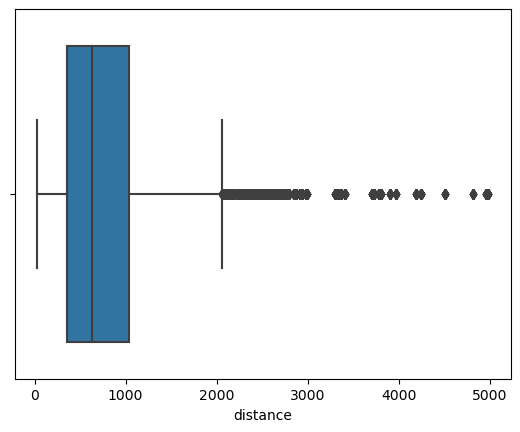

In [25]:
sns.boxplot(x=df['distance'])

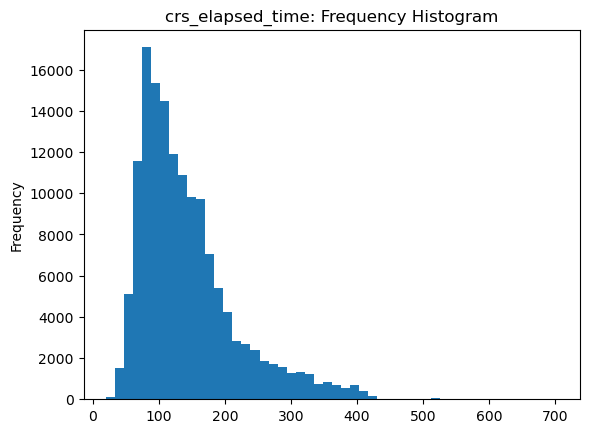

In [22]:
plt.hist(df['crs_elapsed_time'], bins=50)
plt.gca().set(title='crs_elapsed_time: Frequency Histogram', ylabel='Frequency');

<AxesSubplot:xlabel='crs_elapsed_time'>

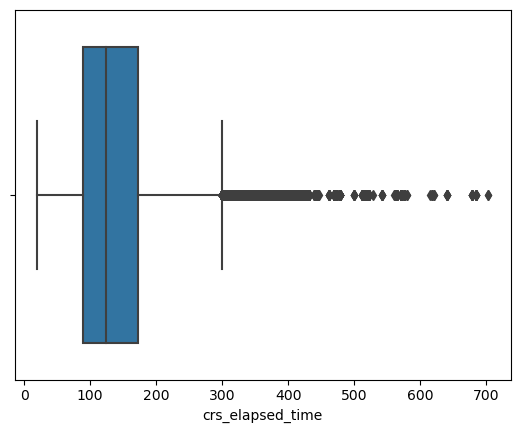

In [26]:
sns.boxplot(x=df['crs_elapsed_time'])

In [27]:
# Both distance and crs_elapsed_time are not normally distributed and contain a large number of outliers (and the extremes have very large outliers).
# Scaling the data has been done using standardization, as to preserve the distribution and not be suceptible to these outliers.

In [54]:
# encode airline company using dummy variables
df_encoded = pd.get_dummies(data=df, columns=['mkt_unique_carrier'], drop_first=False)
df_encoded = pd.get_dummies(data=df_encoded, columns=['dep_day_of_week'], drop_first=False)
# df_encoded['dep_day_of_week_Monday'].dtype
df_encoded.columns

Index(['fl_date', 'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'origin_airport_id', 'origin', 'origin_city_name', 'dest_airport_id',
       'dest', 'dest_city_name', 'crs_dep_time', 'crs_arr_time',
       'crs_elapsed_time', 'distance', 'arr_delay', 'delay_yn', 'holiday',
       'dep_hour', 'arr_hour', 'mkt_unique_carrier_AA',
       'mkt_unique_carrier_AS', 'mkt_unique_carrier_B6',
       'mkt_unique_carrier_DL', 'mkt_unique_carrier_F9',
       'mkt_unique_carrier_G4', 'mkt_unique_carrier_HA',
       'mkt_unique_carrier_NK', 'mkt_unique_carrier_UA',
       'mkt_unique_carrier_WN', 'dep_day_of_week_Friday',
       'dep_day_of_week_Monday', 'dep_day_of_week_Saturday',
       'dep_day_of_week_Sunday', 'dep_day_of_week_Thursday',
       'dep_day_of_week_Tuesday', 'dep_day_of_week_Wednesday'],
      dtype='object')

# Stratified K-fold Cross Validation with logistic regression
#####  Stratified K-fold has less overfitting bias than train/test split and allows stratification. 

In [34]:
# Split the data into target and independent variables
X = df[['distance','crs_elapsed_time','holiday','dep_hour','arr_hour']]
y = df['delay_yn']

In [35]:
X.head(5)

,distance,crs_elapsed_time,holiday,dep_hour,arr_hour
0,815,156,1,6,9
1,227,69,1,10,11
2,333,90,1,22,23
3,737,134,1,9,12
4,737,154,1,12,15


In [37]:
log_reg = LogisticRegression()

In [36]:
# Split the data using Stratified Kfold
skf1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [38]:
# Loop over the folds and train/evaluate the model on each fold
for fold_idx, (train_idx, test_idx) in enumerate(skf1.split(X, y)):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the model on the training set
    log_reg.fit(X_train, y_train)
    
    # Evaluate the model on the testing set
    score = log_reg.score(X_test, y_test)
    print(f"Fold {fold_idx}: accuracy = {score}")
    # input("\nOne Fold Done")
    print("fold_idx : ",fold_idx,'\n')

Fold 0: accuracy = 0.6457193960031644
fold_idx :  0 

Fold 1: accuracy = 0.6423485708389227
fold_idx :  1 

Fold 2: accuracy = 0.6439995872458982
fold_idx :  2 

Fold 3: accuracy = 0.6439995872458982
fold_idx :  3 

Fold 4: accuracy = 0.6448816730875069
fold_idx :  4 



# Model:  Random Forest
##### Unlike logistic regression, random forests are able to and in many cases perform better without encoding. 
##### Additionally, sclaing is not necessary.  If we were scaling, esp the distance and crs_elapsed_time, robust or standard scalar would be preferred; potentially with a transofmration for outliers.

In [55]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']

numeric_df = df_encoded.select_dtypes(include=numerics)
numeric_df.columns

Index(['mkt_carrier_fl_num', 'origin_airport_id', 'dest_airport_id',
       'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time', 'distance',
       'arr_delay', 'delay_yn', 'holiday', 'dep_hour', 'arr_hour',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_WN',
       'dep_day_of_week_Friday', 'dep_day_of_week_Monday',
       'dep_day_of_week_Saturday', 'dep_day_of_week_Sunday',
       'dep_day_of_week_Thursday', 'dep_day_of_week_Tuesday',
       'dep_day_of_week_Wednesday'],
      dtype='object')

In [73]:
X = df_encoded[['crs_elapsed_time', 'distance',
       'holiday', 'dep_hour', 'arr_hour',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_WN',
       'dep_day_of_week_Friday', 'dep_day_of_week_Monday',
       'dep_day_of_week_Saturday', 'dep_day_of_week_Sunday',
       'dep_day_of_week_Thursday', 'dep_day_of_week_Tuesday',
       'dep_day_of_week_Wednesday']]
y = df_encoded['delay_yn']
feature_list = list(X.columns)
X.head(5)

,crs_elapsed_time,distance,holiday,dep_hour,arr_hour,mkt_unique_carrier_AA,mkt_unique_carrier_AS,mkt_unique_carrier_B6,mkt_unique_carrier_DL,mkt_unique_carrier_F9,...,mkt_unique_carrier_NK,mkt_unique_carrier_UA,mkt_unique_carrier_WN,dep_day_of_week_Friday,dep_day_of_week_Monday,dep_day_of_week_Saturday,dep_day_of_week_Sunday,dep_day_of_week_Thursday,dep_day_of_week_Tuesday,dep_day_of_week_Wednesday
0,156,815,1,6,9,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,69,227,1,10,11,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,90,333,1,22,23,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,134,737,1,9,12,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,154,737,1,12,15,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [80]:
rfc = RandomForestClassifier(n_estimators=100, max_depth = 5)

In [81]:
# Split the data using Stratified Kfold
skf2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [82]:
# Loop over the folds and train/evaluate the model on each fold
for fold_idx, (train_idx, test_idx) in enumerate(skf2.split(X, y)):
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Train the model on the training set
    rfc.fit(X_train, y_train)
    
    # Evaluate the model on the testing set
    score = rfc.score(X_test, y_test)
    print(f"Fold {fold_idx}: accuracy = {score}")
    # input("\nOne Fold Done")
    print("fold_idx : ",fold_idx,'\n')

Fold 0: accuracy = 0.6519107075293228
fold_idx :  0 

Fold 1: accuracy = 0.65215148075534
fold_idx :  1 

Fold 2: accuracy = 0.6518075190038868
fold_idx :  2 

Fold 3: accuracy = 0.6514291610772882
fold_idx :  3 

Fold 4: accuracy = 0.6525866813428729
fold_idx :  4 



In [85]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: mkt_unique_carrier_DL Importance: 0.3
Variable: dep_hour             Importance: 0.16
Variable: dep_day_of_week_Wednesday Importance: 0.13
Variable: arr_hour             Importance: 0.11
Variable: mkt_unique_carrier_WN Importance: 0.08
Variable: dep_day_of_week_Friday Importance: 0.04
Variable: mkt_unique_carrier_UA Importance: 0.03
Variable: crs_elapsed_time     Importance: 0.02
Variable: distance             Importance: 0.02
Variable: dep_day_of_week_Monday Importance: 0.02
Variable: holiday              Importance: 0.01
Variable: mkt_unique_carrier_AA Importance: 0.01
Variable: mkt_unique_carrier_AS Importance: 0.01
Variable: mkt_unique_carrier_B6 Importance: 0.01
Variable: mkt_unique_carrier_G4 Importance: 0.01
Variable: dep_day_of_week_Saturday Importance: 0.01
Variable: dep_day_of_week_Thursday Importance: 0.01
Variable: dep_day_of_week_Tuesday Importance: 0.01
Variable: mkt_unique_carrier_F9 Importance: 0.0
Variable: mkt_unique_carrier_HA Importance: 0.0
Variable: mkt_

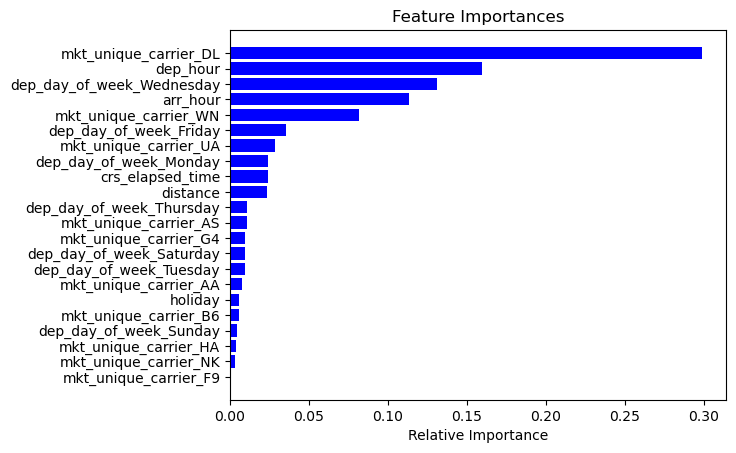

In [86]:
features = feature_list
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()